In [25]:
import torch
import torch.nn as nn
import torch.fx as fx
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [12]:
DATA_ROOT = "../data"
tx = transforms.Compose([transforms.RandomCrop(28, padding=4),
                         transforms.RandomHorizontalFlip(p=0.5),
                         transforms.ToTensor(), 
                         transforms.Normalize([0.2860], [0.3530])
                         ])

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [3]:
train_ds = datasets.FashionMNIST(
    root=DATA_ROOT,
    train=True,
    transform=tx,
    download=True
)
print(len(train_ds))

test_ds = datasets.FashionMNIST(
    root=DATA_ROOT,
    train=False,
    transform=tx,
    download=True
)
print(len(test_ds))

60000
10000


In [13]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

In [14]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([64, 1, 28, 28]) torch.Size([64])


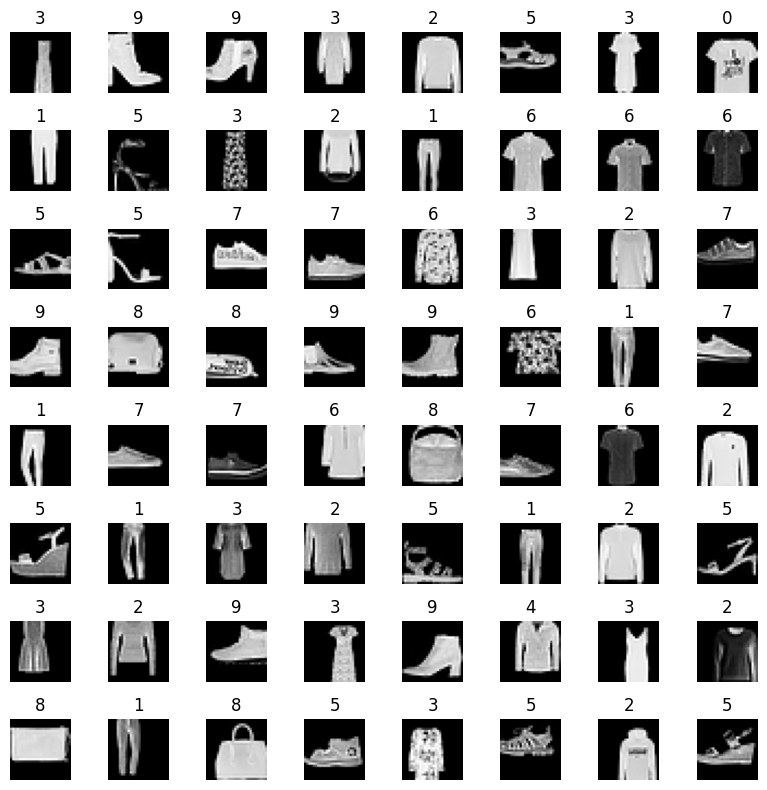

In [15]:
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(0), cmap="gray")
    plt.title(int(labels[i]))

plt.tight_layout()
plt.show()

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(p=0.1),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(p=0.1),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Dropout(p=0.5), nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(), nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

net = FashionCNN()
print(net)
test_result = net.forward(images)
print(test_result.shape)

FashionCNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.3, inplace=False)
    (14): AdaptiveAvgPool2d(output_size=(1, 1))
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=128, out_features

In [ ]:
num_epochs = 30
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
num_epochs = 30
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
@torch.no_grad()
def evaluate(model, criterion, loader, device=device):
    model.eval()
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += float(loss.item())
        pred = logits.argmax(dim=1)
        total_correct += int((pred == y).sum().item())
        total_samples += int(y.size(0))
    
    avg_loss = running_loss / len(loader)
    acc = total_correct / max(1, total_samples)
    return {"loss": avg_loss, "acc": acc}

In [19]:
best_acc = -1.0
train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    running = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += float(loss.item())
    train_loss = running / len(train_loader)

    metrics = evaluate(model, criterion, test_loader)
    val_loss = metrics["loss"]
    val_acc = metrics["acc"]

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    scheduler.step()

    print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"train={train_loss:.4f}  val={val_loss:.4f}  acc={val_acc*100:5.2f}%")


Epoch 01/20 | train=0.7872  val=0.6147  acc=77.63%
Epoch 02/20 | train=0.5356  val=0.4900  acc=82.35%
Epoch 03/20 | train=0.4795  val=0.4628  acc=83.43%
Epoch 04/20 | train=0.4459  val=0.4107  acc=85.42%
Epoch 05/20 | train=0.4213  val=0.4097  acc=85.39%
Epoch 06/20 | train=0.4016  val=0.4004  acc=85.82%
Epoch 07/20 | train=0.3908  val=0.3777  acc=86.86%
Epoch 08/20 | train=0.3749  val=0.3662  acc=87.09%
Epoch 09/20 | train=0.3668  val=0.3482  acc=87.46%
Epoch 10/20 | train=0.3567  val=0.3352  acc=87.97%
Epoch 11/20 | train=0.3481  val=0.3359  acc=88.32%
Epoch 12/20 | train=0.3429  val=0.3517  acc=87.46%
Epoch 13/20 | train=0.3353  val=0.3285  acc=88.33%
Epoch 14/20 | train=0.3274  val=0.3171  acc=88.55%
Epoch 15/20 | train=0.3229  val=0.3130  acc=88.97%
Epoch 16/20 | train=0.3206  val=0.3103  acc=88.88%
Epoch 17/20 | train=0.3173  val=0.3068  acc=89.24%
Epoch 18/20 | train=0.3155  val=0.3159  acc=88.76%
Epoch 19/20 | train=0.3119  val=0.3022  acc=89.48%
Epoch 20/20 | train=0.3112  val

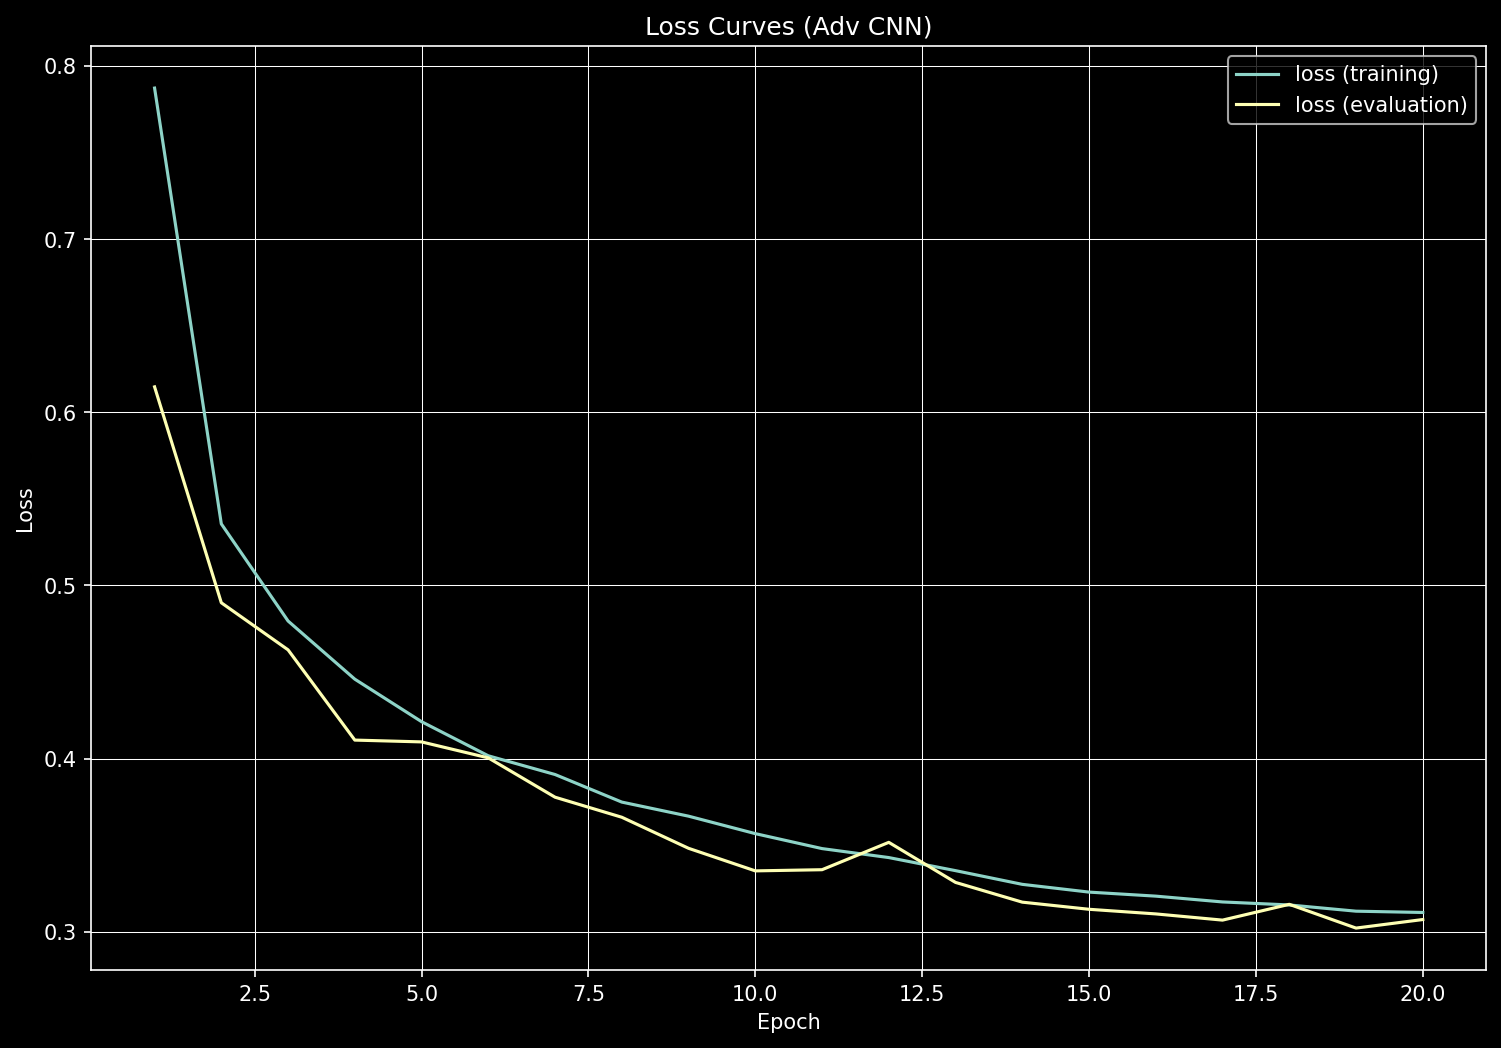

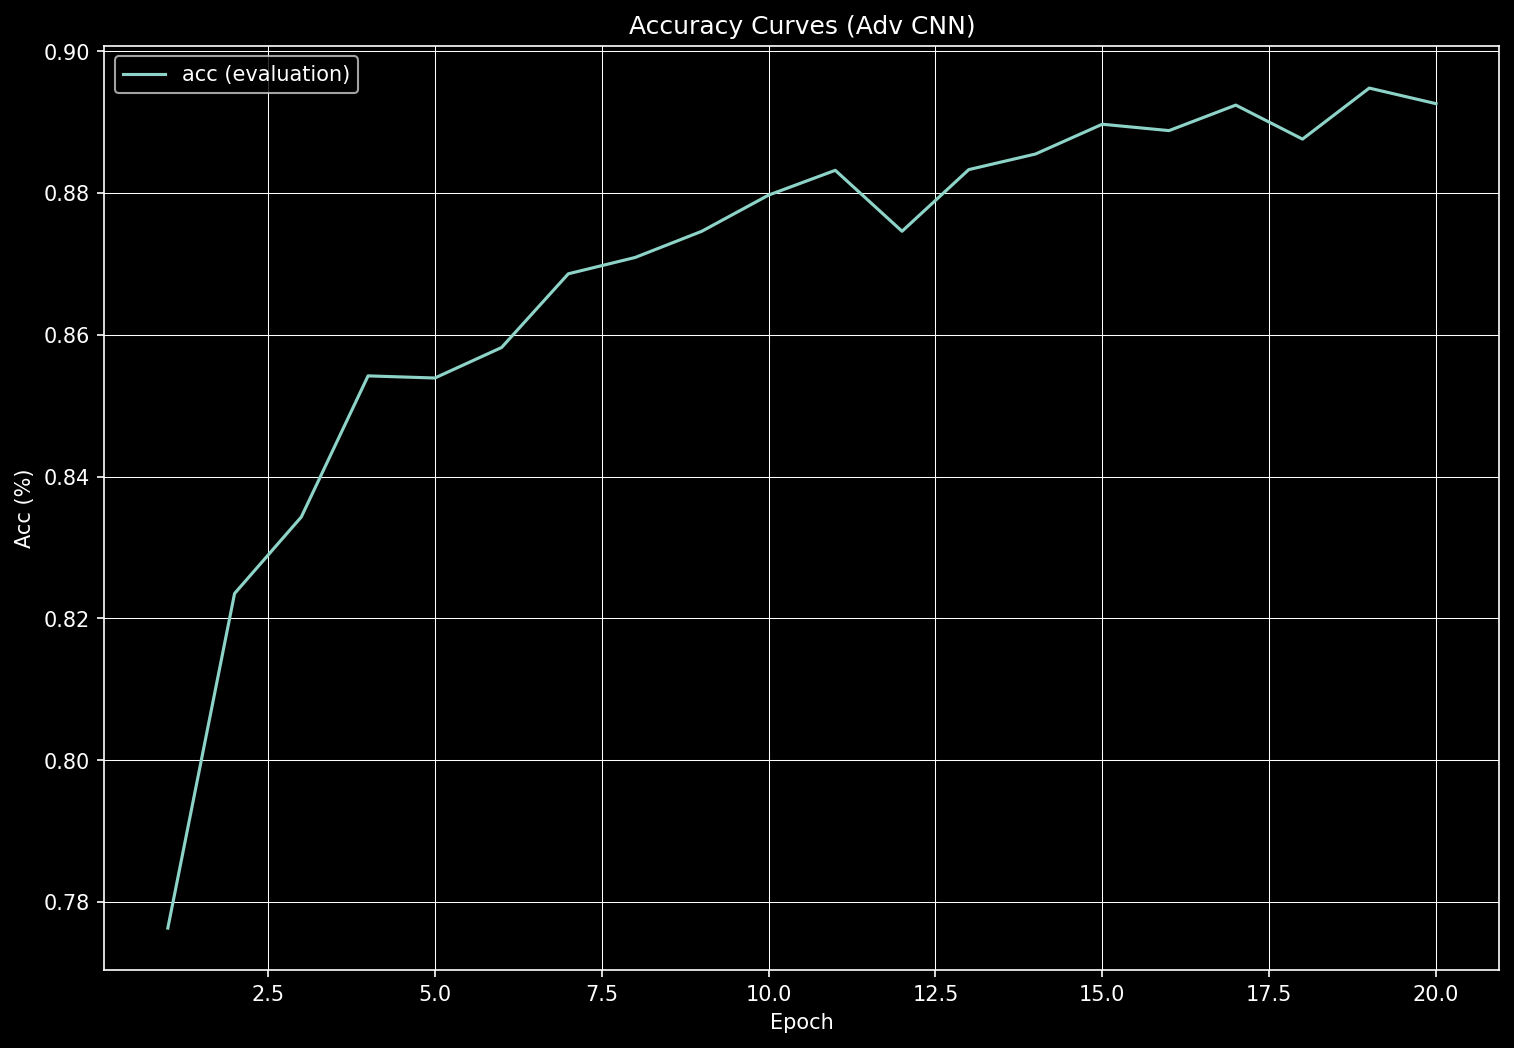

In [21]:
plt.style.use("dark_background")

epoch_x = np.arange(1, 21)
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(epoch_x, train_losses, label='loss (training)')
plt.plot(epoch_x, val_losses, label='loss (evaluation)')
plt.grid(True, linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves (Adv CNN)")
plt.savefig("../results/loss_curve_adv.png")
plt.show()

plt.figure(figsize=(12, 8), dpi=150)
plt.plot(epoch_x, val_accs, label='acc (evaluation)')
plt.grid(True, linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel("Acc (%)")
plt.legend()
plt.title("Accuracy Curves (Adv CNN)")
plt.savefig("../results/accuracy_curve_adv.png")
plt.show()

In [31]:
@torch.no_grad()
def collect_misclassified(model, loader, device=device):
    model.eval()
    wrong_images, wrong_preds, wrong_labels = [], [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)

        mask = (pred != y)
        if mask.any():
            x_wrong = x[mask].detach().cpu()
            pred_wrong = pred[mask].detach().cpu()
            y_wrong = y[mask].detach().cpu()

            wrong_images.append(x_wrong)
            wrong_preds.append(pred_wrong)
            wrong_labels.append(y_wrong)

    if len(wrong_images) == 0:
        return None, None, None
    
    wrong_images = torch.cat(wrong_images, dim=0)
    wrong_preds  = torch.cat(wrong_preds, dim=0)
    wrong_labels = torch.cat(wrong_labels, dim=0)
    return wrong_images, wrong_preds, wrong_labels

def denormalize(img_tensor, mean=0.2860, std=0.3530):
    return img_tensor * std + mean

CLASSES = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
           "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

def pick_first_n(images, preds, labels, N=25):
    N = min(N, images.size(0))
    return images[:N], preds[:N], labels[:N]

def plot_misclassified_grid(images, preds, labels, save_path, nrow=5):

    N = images.size(0)
    ncol = nrow
    nrow = int(np.ceil(N / ncol))

    plt.figure(figsize=(ncol*2.4, nrow*2.4), dpi=150)
    for i in range(N):
        plt.subplot(nrow, ncol, i+1)
        img = denormalize(images[i]).squeeze(0).numpy()
        plt.imshow(img, cmap="gray")
        true_name = CLASSES[int(labels[i])]
        pred_name = CLASSES[int(preds[i])]
        plt.title(f"T:{true_name}\nP:{pred_name}", fontsize=8)
        plt.axis("off")

    plt.tight_layout(pad=0.6)
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

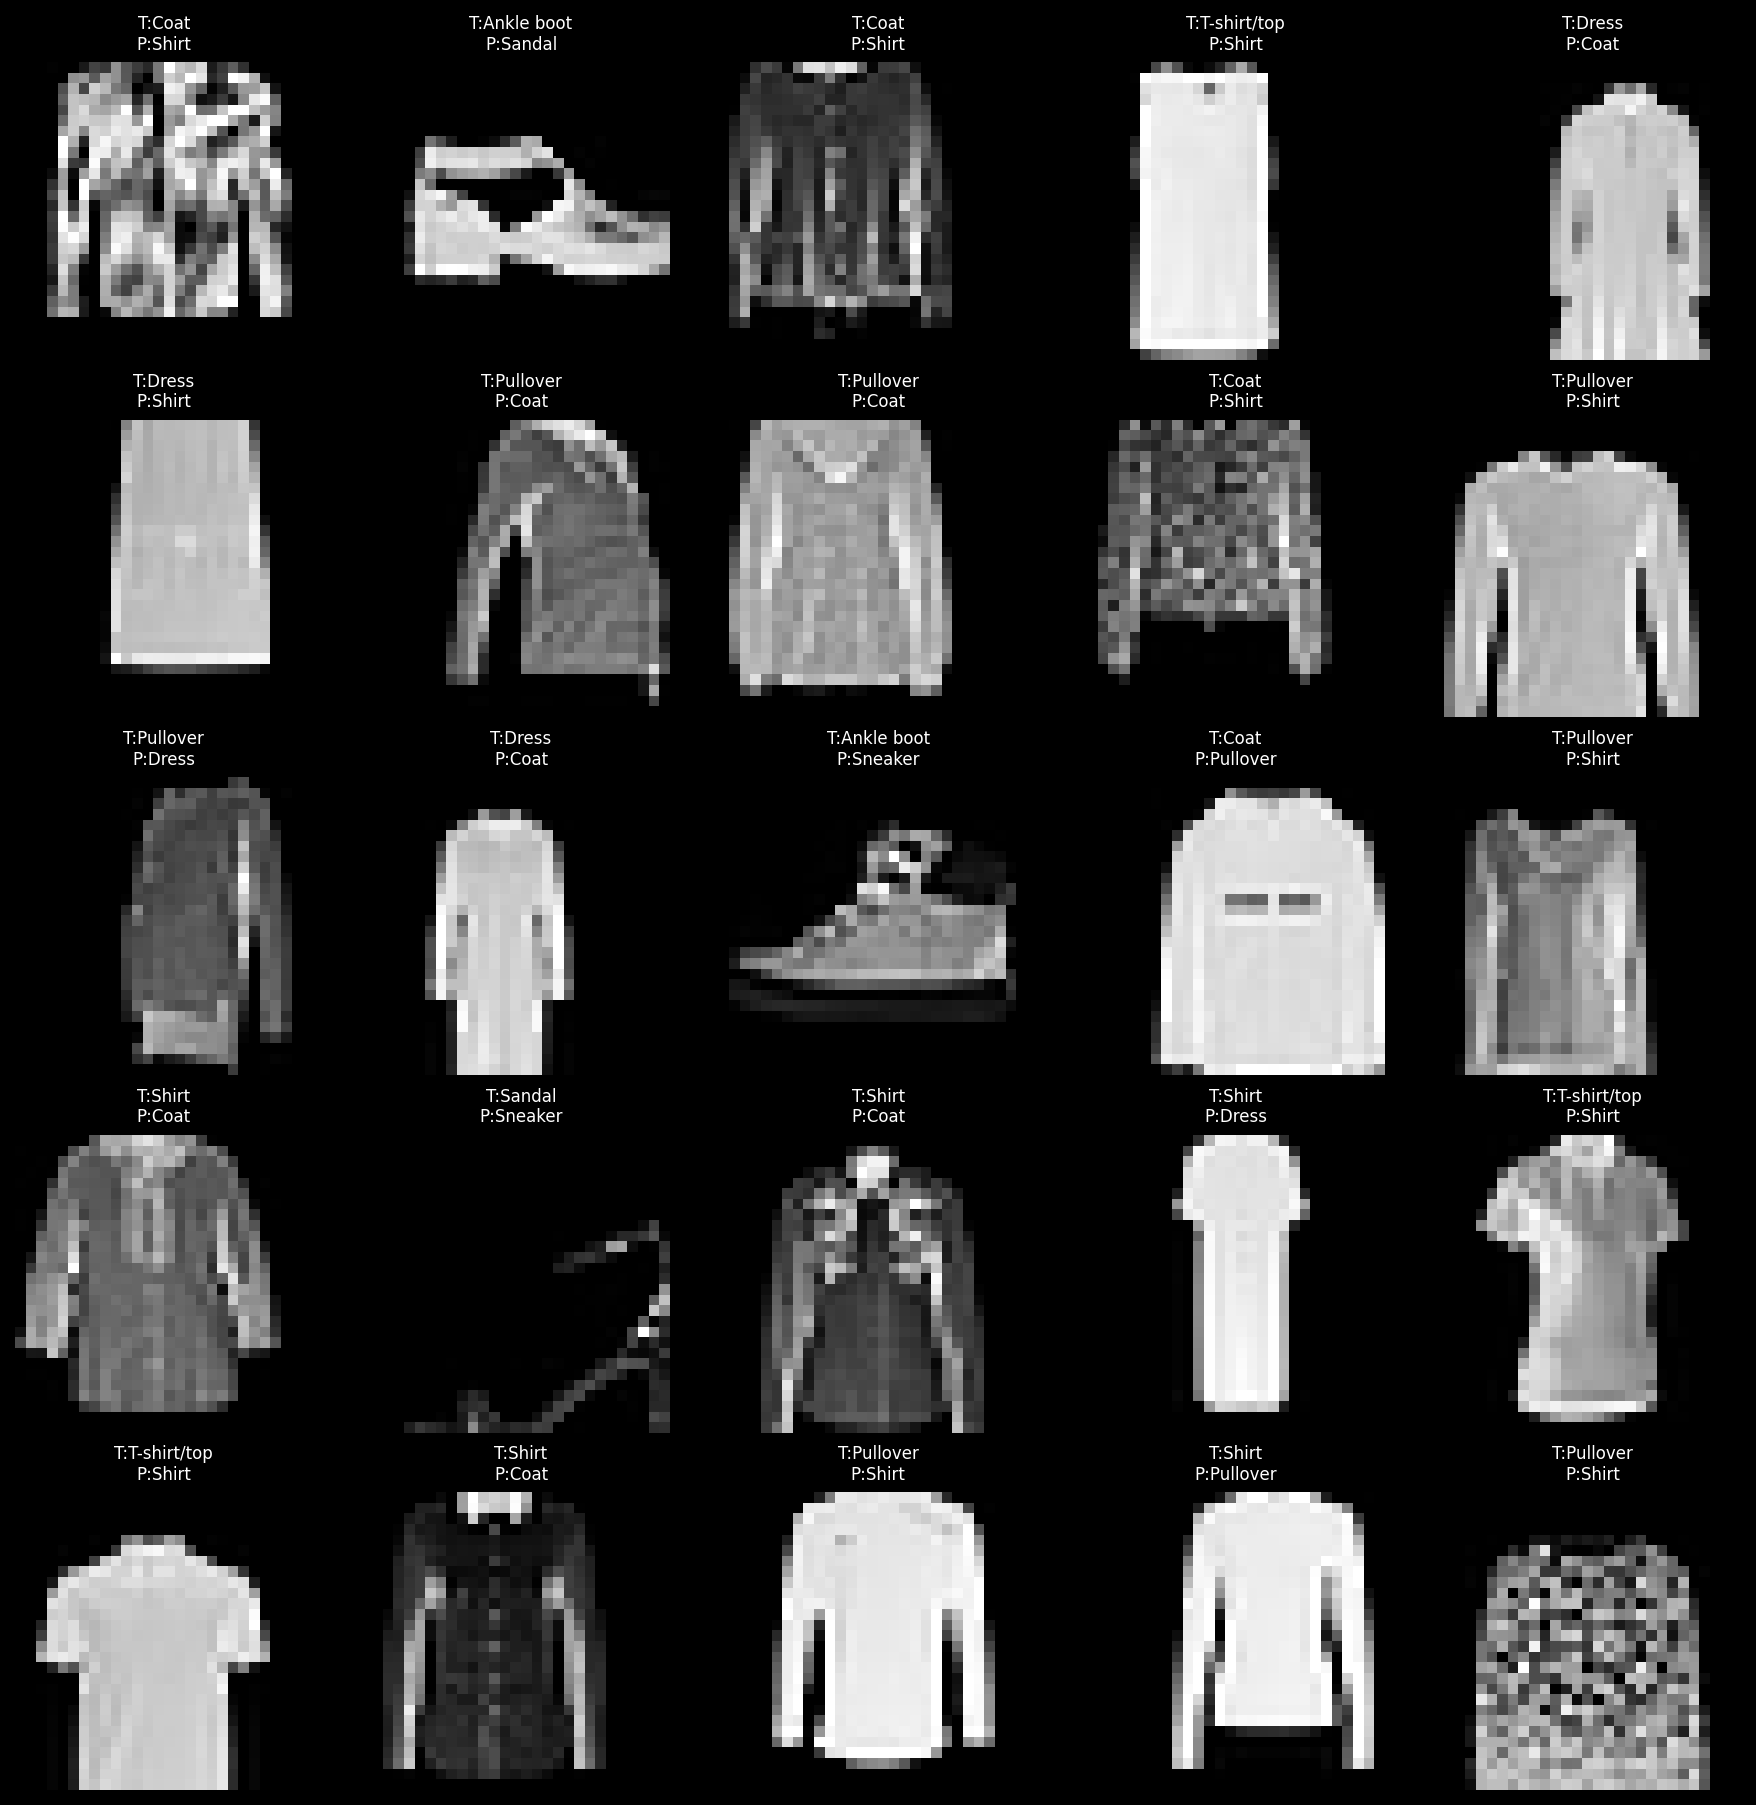

In [32]:
wrong_imgs, wrong_preds, wrong_labels = collect_misclassified(model, test_loader, device)

sel_imgs, sel_preds, sel_labels = pick_first_n(wrong_imgs, wrong_preds, wrong_labels, N=25)
plot_misclassified_grid(
    sel_imgs, sel_preds, sel_labels,
    save_path="../results/misclassified/misclassified_samples.png",
    nrow=5
)

In [37]:
def visualize_filters(layer, ncols=8, save_path=None):
    """
    Visualize the filters (weights) of a Conv2d layer.
    
    Args:
        layer: nn.Conv2d layer
        ncols: number of columns in the grid
        save_path: if not None, save the figure to this path
    """
    weights = layer.weight.data.clone().cpu()
    
    if weights.shape[1] > 1:
        weights = weights.mean(dim=1, keepdim=True)

    min_w = weights.min()
    max_w = weights.max()
    weights = (weights - min_w) / (max_w - min_w)

    n_filters = weights.shape[0]
    nrows = int(np.ceil(n_filters / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    axes = axes.flatten()

    for i in range(nrows * ncols):
        axes[i].axis("off")
        if i < n_filters:
            f = weights[i, 0].numpy()
            axes[i].imshow(f, cmap="gray")
    
    plt.tight_layout()
    plt.show()

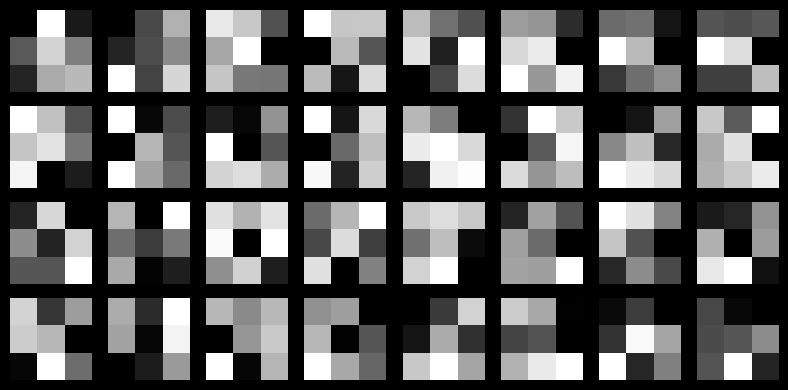

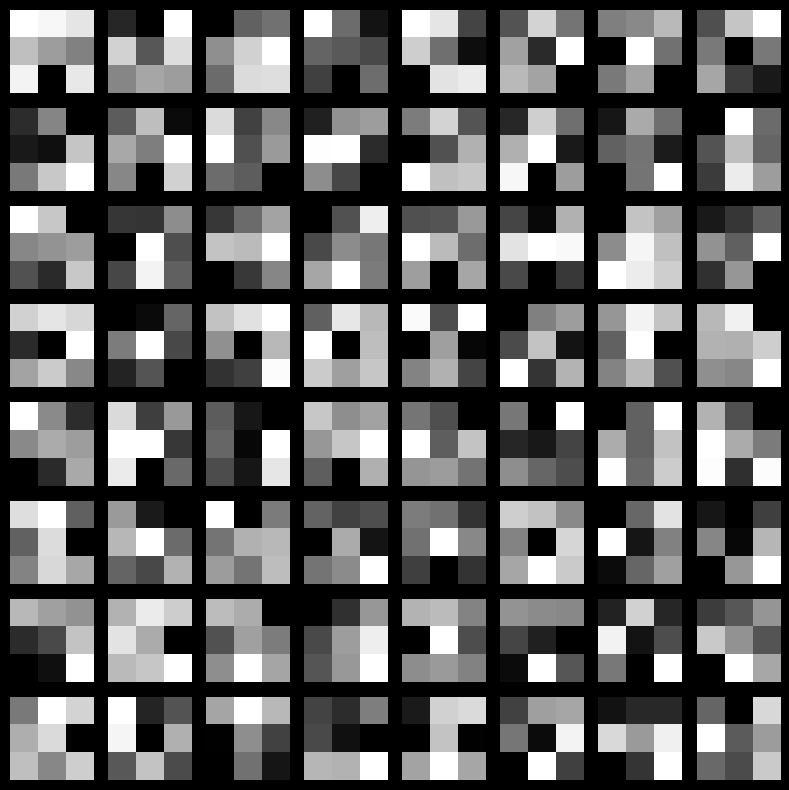

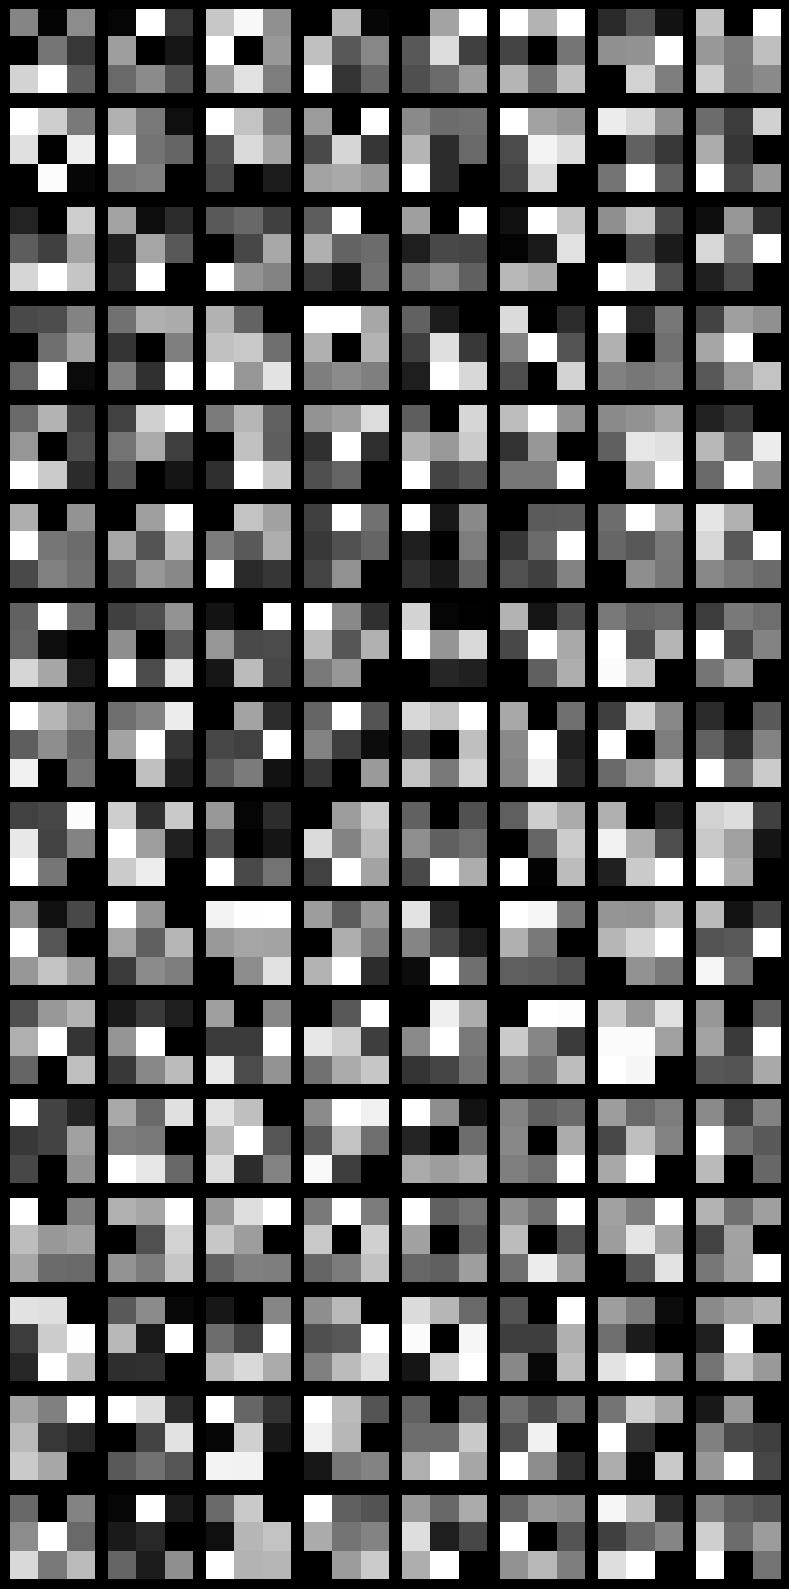

In [38]:
# conv1
visualize_filters(net.net[0], save_path="filters_conv1.png")

# conv2
visualize_filters(net.net[5], save_path="filters_conv2.png")

# conv3
visualize_filters(net.net[10], save_path="filters_conv3.png")
